# Import all modules

In [1]:
# Here we import everything we need for the project

%matplotlib inline
from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

2.15.0


## Kaggle load data

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"victoraesthete","key":"1716ef4b4888a75b2711cfac9b091d09"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! cat kaggle.json

{"username":"victoraesthete","key":"1716ef4b4888a75b2711cfac9b091d09"}

In [7]:
!kaggle datasets download -d gti-upm/leapgestrecog

100% 2.12G/2.13G [00:28<00:00, 89.1MB/s]
100% 2.13G/2.13G [00:28<00:00, 80.1MB/s]


In [8]:
!unzip /content/leapgestrecog.zip

Streaming output truncated to the last 5000 lines.
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapgestrecog/leapGestRe

# EDA on images

In [9]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False):
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

imagepaths = imagepaths[:40000]

print(len(imagepaths)) # If > 0, then a PNG image was loaded

40000


In [10]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


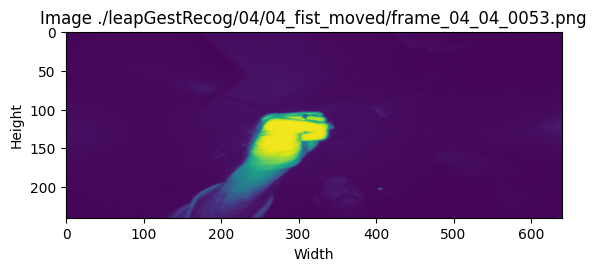

In [11]:
plot_image(imagepaths[0]) #We plot the first image from our imagepaths array

In [12]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)

  # Processing label in image path
  category = path.split("/")[3]
  label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  40000
Labels loaded:  40000
4 ./leapGestRecog/04/04_fist_moved/frame_04_04_0053.png


# Creating the model

In [13]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

In [15]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [16]:
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy'])

In [17]:
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Epoch 1/5
438/438 - 34s - loss: 1.4605 - accuracy: 0.5144 - val_loss: 0.8129 - val_accuracy: 0.5201 - 34s/epoch - 78ms/step
Epoch 2/5
438/438 - 24s - loss: 0.7755 - accuracy: 0.5391 - val_loss: 0.7668 - val_accuracy: 0.5217 - 24s/epoch - 55ms/step
Epoch 3/5
438/438 - 25s - loss: 0.7343 - accuracy: 0.5368 - val_loss: 0.7473 - val_accuracy: 0.5102 - 25s/epoch - 56ms/step
Epoch 4/5
438/438 - 25s - loss: 0.7099 - accuracy: 0.5423 - val_loss: 0.7449 - val_accuracy: 0.5025 - 25s/epoch - 57ms/step
Epoch 5/5
438/438 - 27s - loss: 0.6978 - accuracy: 0.5441 - val_loss: 0.7332 - val_accuracy: 0.5045 - 27s/epoch - 62ms/step


In [18]:
model.save('handrecognition_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing Model

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

94/94 [==============================] - 36s 386ms/step - loss: 3.1994e-05 - accuracy: 1.0000
Test accuracy: 100.00%


In [ ]:
predictions = model.predict(X_test) # Make predictions towards the test set

94/94 [==============================] - 37s 387ms/step


In [ ]:
np.argmax(predictions[0]), y_test[0] # If same, got it right

(6, 6)

In [ ]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"]
  plt.figure(figsize=(15,5))

  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction

    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

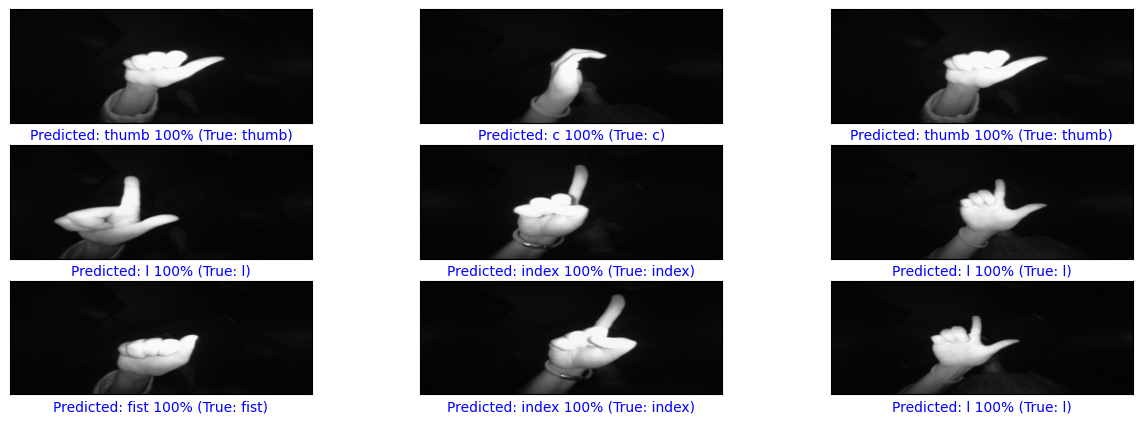

In [ ]:
validate_9_images(predictions, y_test, X_test)

In [ ]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

In [ ]:
# H = Horizontal
# V = Vertical

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])

,Predicted Thumb Down,Predicted Palm (H),Predicted L,Predicted Fist (H),Predicted Fist (V),Predicted Thumbs up,Predicted Index,Predicted OK,Predicted Palm (V),Predicted C
Actual Thumb Down,317,0,0,0,0,0,0,0,0,0
Actual Palm (H),0,254,0,0,0,0,0,0,0,0
Actual L,0,0,304,0,0,0,0,0,0,0
Actual Fist (H),0,0,0,282,0,0,0,0,0,0
Actual Fist (V),0,0,0,0,309,0,0,0,0,0
Actual Thumbs up,0,0,0,0,0,313,0,0,0,0
Actual Index,0,0,0,0,0,0,315,0,0,0
Actual OK,0,0,0,0,0,0,0,323,0,0
Actual Palm (V),0,0,0,0,0,0,0,0,293,0
Actual C,0,0,0,0,0,0,0,0,0,290


# Test with OpenCV on colab

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('/content/handrecognition_model.h5')

def recognize_gesture(frame):
    # Preprocess the frame
    resized_frame = cv2.resize(frame, (224, 224))
    normalized_frame = resized_frame / 255.0
    input_data = np.expand_dims(normalized_frame, axis=0)

    # Predict the gesture
    prediction = model.predict(input_data)
    predicted_class = np.argmax(prediction)

    # Return the predicted class
    return predicted_class

# Open the camera
cap = cv2.VideoCapture(0)

while True:
    # Read a frame from the camera
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    # Display the frame
    cv2.imshow('Camera', frame)

    # Perform hand gesture recognition
    gesture_class = recognize_gesture(frame)
    print("Recognized Class:", gesture_class)
    # You can add your logic here to interpret 'gesture_class' and perform corresponding actions

    # Wait for 'q' key to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close OpenCV windows
cap.release()
cv2.destroyAllWindows()

Failed to capture frame


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('handrecognition_model.h5')

def preprocess_image(frame):
    resized_frame = cv2.resize(frame, (320, 120))
    grayscale_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
    processed_frame = np.expand_dims(grayscale_frame, axis=-1)
    processed_frame = processed_frame / 255.0
    return processed_frame

def recognize_gesture(frame):
    input_data = preprocess_image(frame)
    input_data = np.expand_dims(input_data, axis=0)
    prediction = model.predict(input_data)
    predicted_class = np.argmax(prediction)
    return predicted_class

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break
    cv2.imshow('Camera', frame)
    gesture_class = recognize_gesture(frame)
    print("Recognized Class:", gesture_class)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
